In [1]:
import pandas as pd
import numpy as np
import math
import os
import sys
import datetime


from sklearn.preprocessing import StandardScaler, FunctionTransformer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
from sklearn.decomposition import PCA

C:\Users\ATISHAY SG\AppData\Local\Temp\ipykernel_2812\1561144464.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
import statsmodels.api as sm

In [3]:
## Read data
FILE = 'D:/AAPS/Codes/Data/multivariate_timeseries_data.csv'
df = pd.read_csv(FILE, sep = ",", header = 0)
df['time'] = pd.to_datetime(df['time'], format='%m-%d-%Y %H.%M')
df = df.set_index('time')
df.loc[:, df.columns != 'time'] = df.loc[:, df.columns != 'time'].apply(pd.to_numeric, errors = 'coerce')
s = df.select_dtypes(include = 'object').columns
df[s] = df[s].astype('float')
df.dtypes

Cyclone_Inlet_Gas_Temp      float64
Cyclone_Material_Temp       float64
Cyclone_Outlet_Gas_draft    float64
Cyclone_cone_draft          float64
Cyclone_Gas_Outlet_Temp     float64
Cyclone_Inlet_Draft         float64
dtype: object

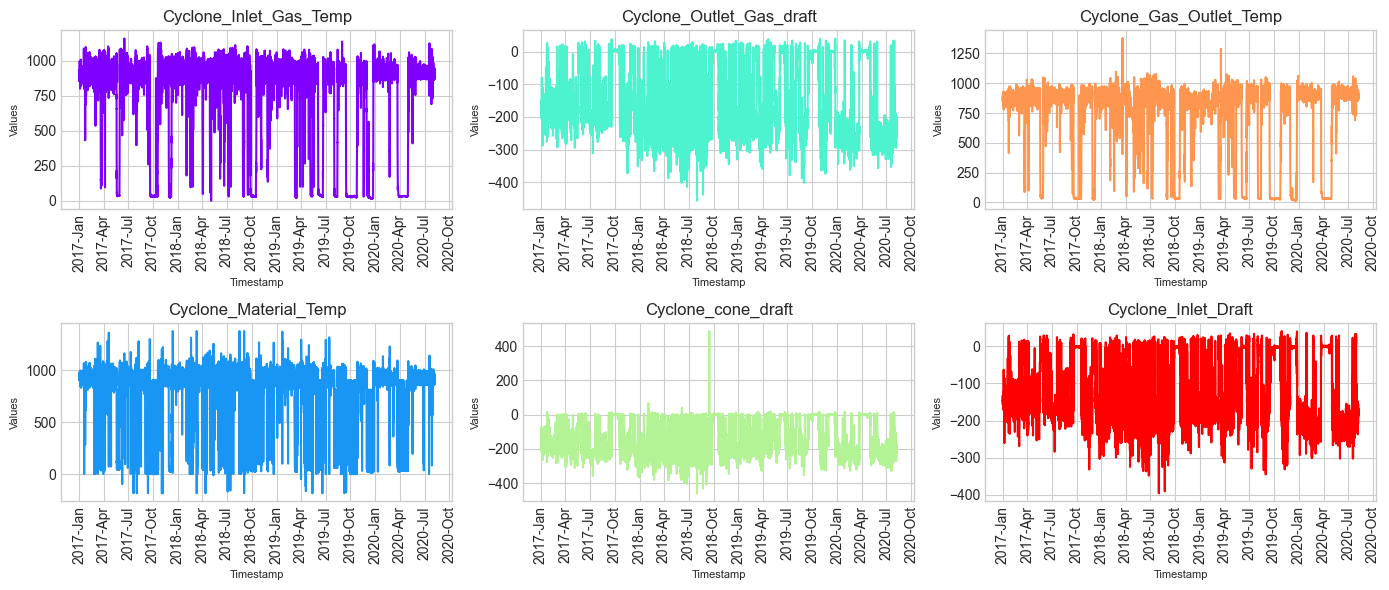

In [4]:
## Plot timeseries data
colors = cm.rainbow(np.linspace(0, 1, 6))
fig, ax = plt.subplots(2, 3, figsize = (14, 6), tight_layout = True)
for i in range(2):
  for j in range(3):
    col = df.columns[i+2*j]
    ax[i,j].plot(df.index[df[col].notna()], df[col][df[col].notna()], color = colors[i+2*j])
    ax[i, j].set_xlabel('Timestamp', fontsize = 8)
    ax[i, j].set_ylabel('Values', fontsize = 8)
    ax[i, j].set_title(col, fontsize = 12)
    ax[i, j].xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1, 12, 3)))
    ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax[i, j].tick_params(axis = 'x', rotation = 90);

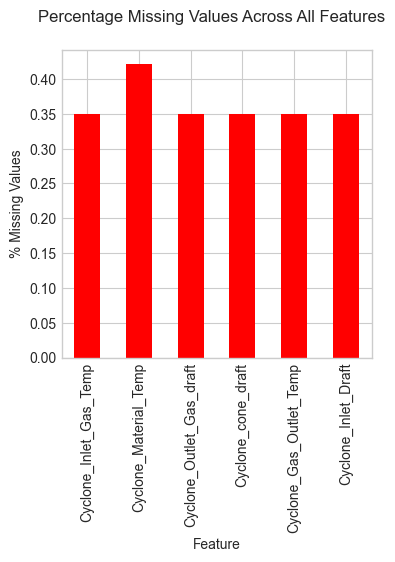

In [5]:
## Plot percentage of missing values (NaNs) for each feature
cutoff  = 1
fig = plt.figure(figsize=(4, 4))
fig.tight_layout()
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 12)
plt.xlabel('Feature', fontsize = 10)
plt.ylabel('% Missing Values', fontsize = 10);

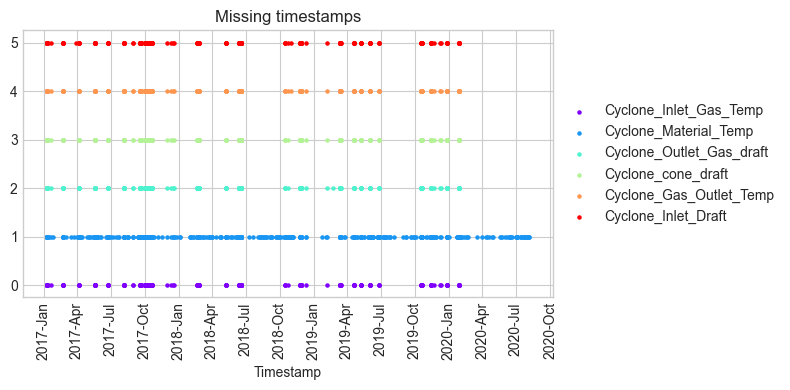

In [6]:
## Get timestamps of missing values for each column
## and plot them
fig, ax = plt.subplots(1, 1, figsize = (8, 4), tight_layout = True)
for j, col in enumerate(df.columns):
  # Get missing timestamps for this column
  missing_value_timestamps = df.index[df[col].isna()]
  # Plot missing timestamps for this column
  ax.scatter(missing_value_timestamps, [0+j] * len(missing_value_timestamps),
              color = colors[j],
              s = 5,
              label = col)

ax.set_title('Missing timestamps', fontsize = 12)
ax.set_xlabel('Timestamp', fontsize = 10)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1, 12, 3)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.tick_params(axis = 'x', rotation = 90);

In [7]:
## Linear interpolation for missing values
#df['Cyclone_Inlet_Gas_Temp'] = df['Cyclone_Inlet_Gas_Temp'].interpolate(method = 'linear')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].interpolate(method = 'linear')
(df.isna().sum() / df.shape[0]) * 100

Cyclone_Inlet_Gas_Temp      0.0
Cyclone_Material_Temp       0.0
Cyclone_Outlet_Gas_draft    0.0
Cyclone_cone_draft          0.0
Cyclone_Gas_Outlet_Temp     0.0
Cyclone_Inlet_Draft         0.0
dtype: float64

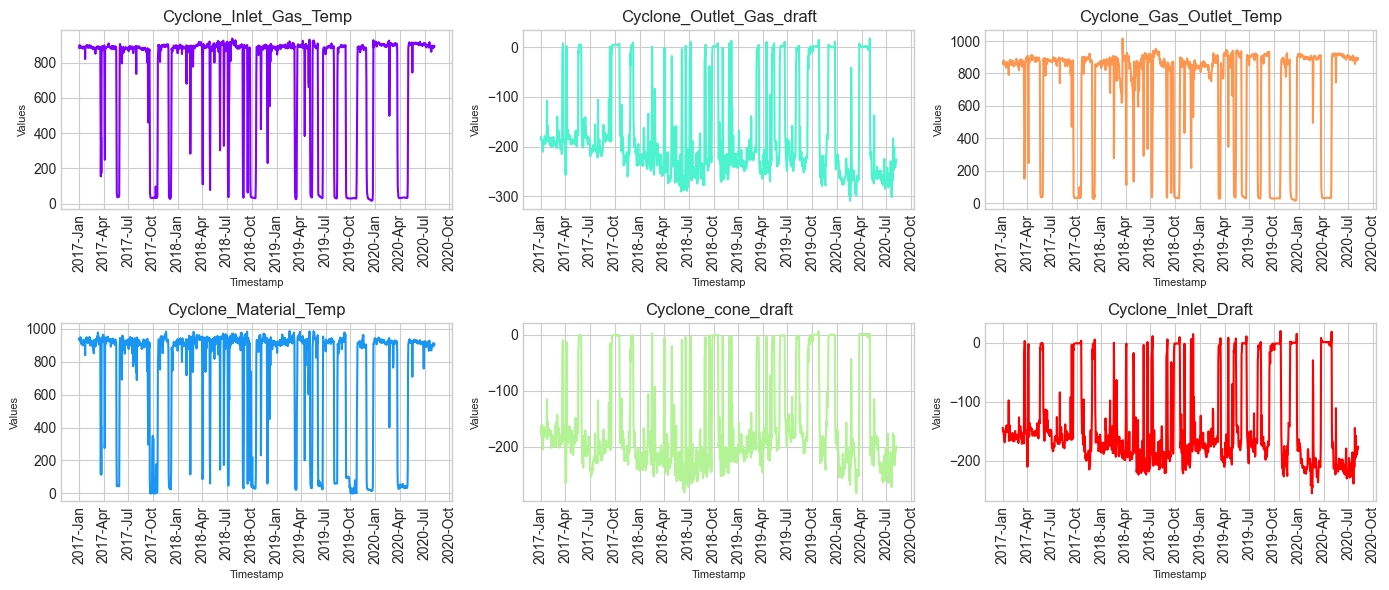

In [8]:
## Downsample to daily frequency and plot timeseries data
df_daily = df.resample('D').mean()
fig, ax = plt.subplots(2, 3, figsize = (14, 6), tight_layout = True)
for i in range(2):
  for j in range(3):
    col = df_daily.columns[i+2*j]
    ax[i,j].plot(df_daily.index[df_daily[col].notna()], df_daily[col][df[col].notna()], color = colors[i+2*j])
    ax[i, j].set_xlabel('Timestamp', fontsize = 8)
    ax[i, j].set_ylabel('Values', fontsize = 8)
    ax[i, j].set_title(col, fontsize = 12)
    ax[i, j].xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1, 12, 3)))
    ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax[i, j].tick_params(axis = 'x', rotation = 90);

In [9]:
## Data preparation for anomaly detection using numpy
# Note that 5min is the sampling period in the dataset which
# we specify and convert to seconds
sampling_period = int(pd.Timedelta('5min').total_seconds())
# We are interested in 30min data for each sample which
# we specify and convert to seconds
time_period = int(pd.Timedelta('30min').total_seconds())
# The following is a dictionary that we will use for transforming the columns
# 'identity' corresponds to no transformation, 'standard' means standardizing
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['standard'].fit_transform(df))
df_transformed.columns = df.columns.copy()
df_transformed.index = df.index.copy()
ncols_reshape = int(pd.Timedelta(str(time_period/sampling_period)+'S').total_seconds())
nrows_reshape = df_transformed.shape[0]//ncols_reshape
df_samples = pd.DataFrame(np.concatenate([np.array(df_transformed[feature])[0:nrows_reshape*ncols_reshape].reshape(nrows_reshape, ncols_reshape) for feature in df_transformed.columns.values], axis = 1))
df_samples.index = pd.date_range(df_transformed.index.min(),
                                 df_transformed.index.max() + pd.DateOffset(days = 1),
                                 normalize = True,
                                 freq = str(time_period)+'S')[0:df_samples.shape[0]]
df_samples.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2017-01-01 00:00:00,0.429433,0.464612,0.453816,0.452633,0.502307,0.462519,0.457338,0.479265,0.496420,0.493495,...,0.464489,0.463846,0.495128,0.477510,-0.062775,-0.112398,-0.051333,-0.023179,-0.030507,-0.075887
2017-01-01 00:30:00,0.545613,0.460366,0.439684,0.544157,0.452117,0.531238,0.573506,0.540303,0.537747,0.538684,...,0.480697,0.480697,0.502940,0.508762,-0.139009,-0.111626,-0.059175,-0.101085,-0.040920,-0.010580
2017-01-01 01:00:00,0.450298,0.474316,0.436924,0.522959,0.408417,0.499820,0.506731,0.536156,0.499687,0.553567,...,0.459005,0.510539,0.448281,0.490103,-0.109955,-0.031149,-0.072802,0.006004,0.021688,-0.117540
2017-01-01 01:30:00,0.412936,0.440836,0.502550,0.430555,0.428827,0.433861,0.491450,0.482077,0.520790,0.491052,...,0.496966,0.471505,0.464489,0.460598,-0.037449,-0.065603,-0.039763,-0.038092,-0.023436,0.008832
2017-01-01 02:00:00,0.468827,0.495363,0.438895,0.441139,0.447265,0.455574,0.518149,0.541553,0.536810,0.514258,...,0.498559,0.488908,0.495587,0.484128,0.062955,0.028758,-0.078330,-0.002481,-0.052490,-0.056475


---

Exploratory Data Analysis

---

In [58]:
#Is the data stationary? #Dicky Fuller test 
from statsmodels.tsa.stattools import adfuller 
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df_samples[0]) 
print('ADF Statistic: %f' % adf)

ADF Statistic: -8.014133


In [11]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
year = df['year'].unique()

In [12]:
df['year'].unique()

array([2017, 2018, 2019, 2020], dtype=int64)

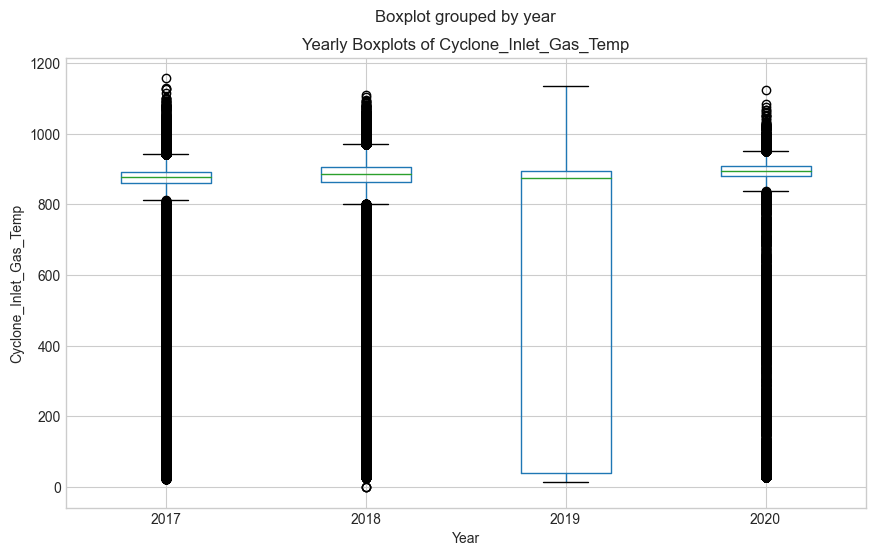

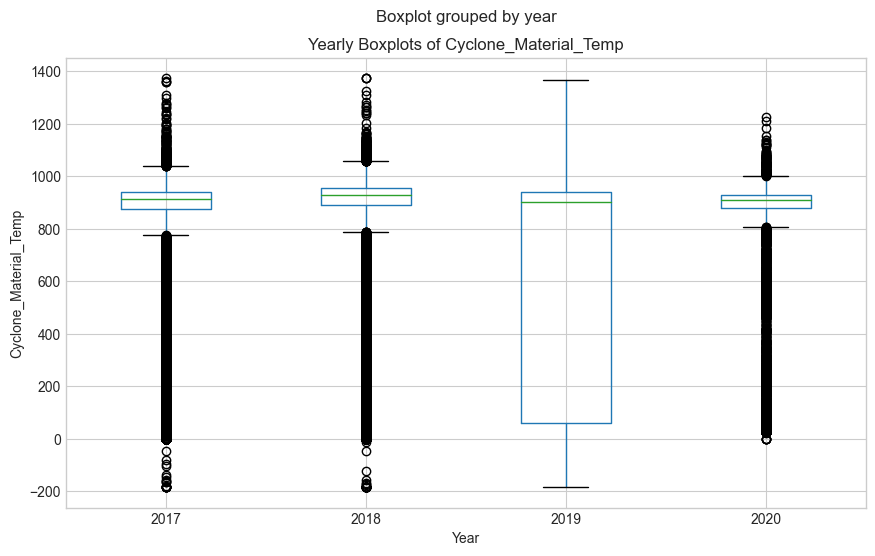

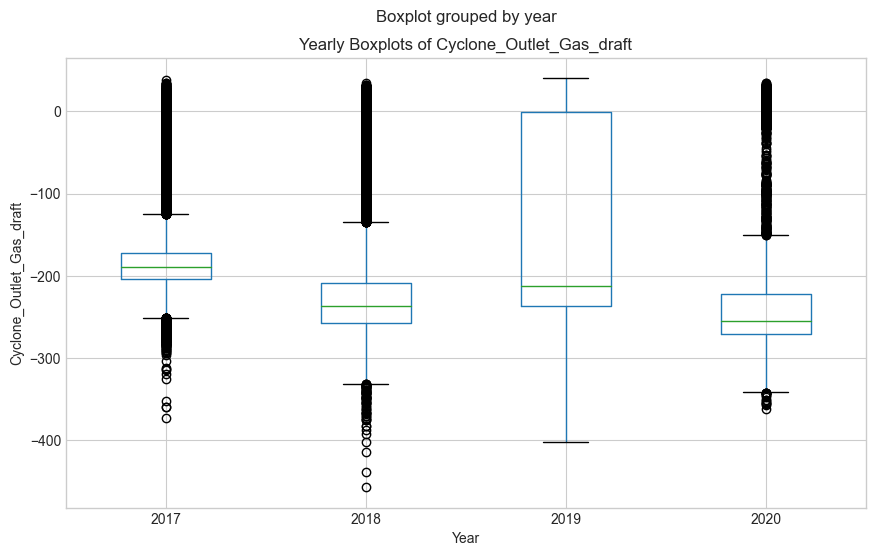

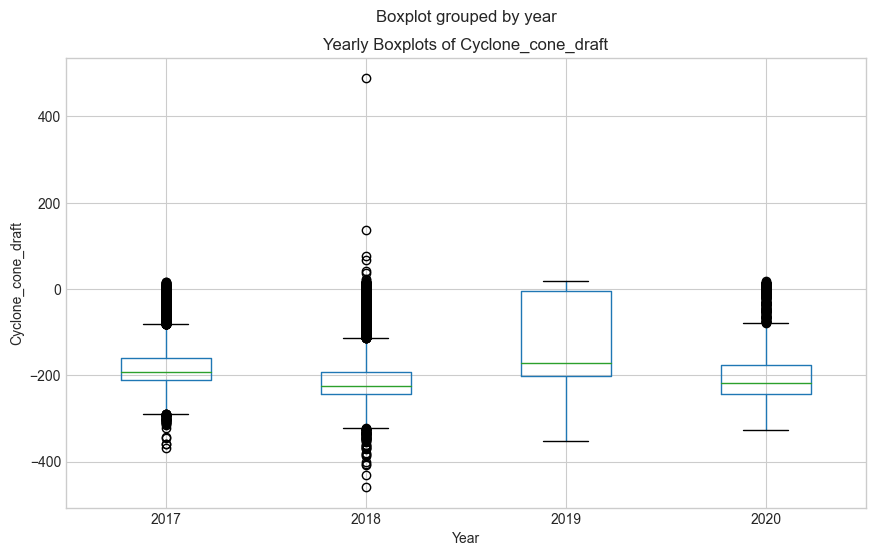

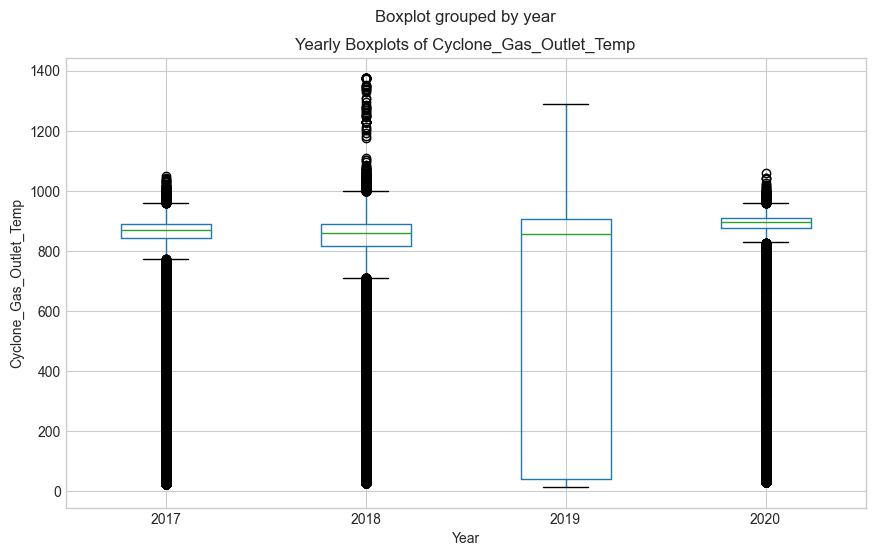

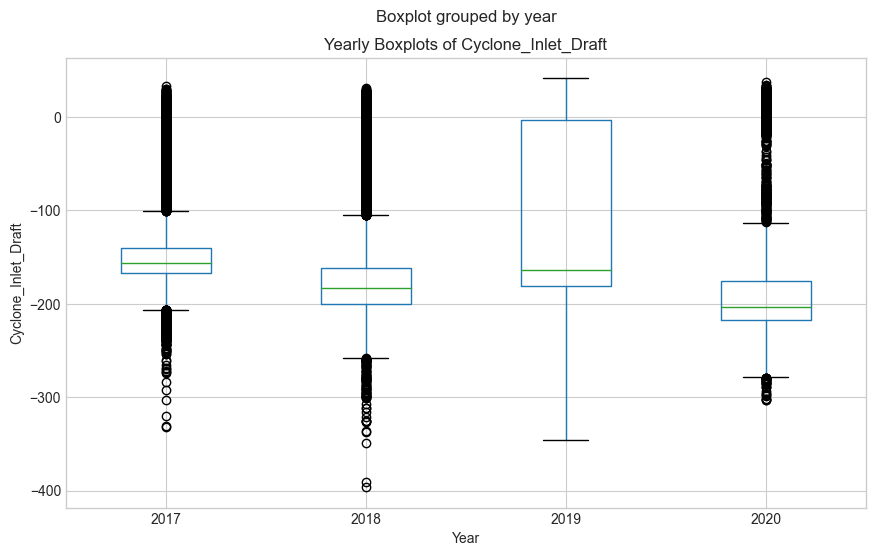

In [24]:
# Plot yearly boxplots for all features
for column in df.columns:
    if column != 'year' and column != 'month':  # Skip 'year' and 'month' columns
        fig, ax = plt.subplots(figsize=(10, 6))
        df.boxplot(column=column, by='year', ax=ax)
        ax.set_xlabel('Year')
        ax.set_ylabel(column)
        ax.set_title(f'Yearly Boxplots of {column}')
plt.show()

In [26]:
# Loop over each column (excluding 'year' and 'month' columns if present)
for column in df.columns:
    if column != 'year' and column != 'month':  # Skip 'year' and 'month' columns
        # Perform seasonal decomposition
        decomposed = seasonal_decompose(df[column], model='additive', period=1)

In [27]:
trend = decomposed.trend
seasonal = decomposed.seasonal 
residual = decomposed.resid


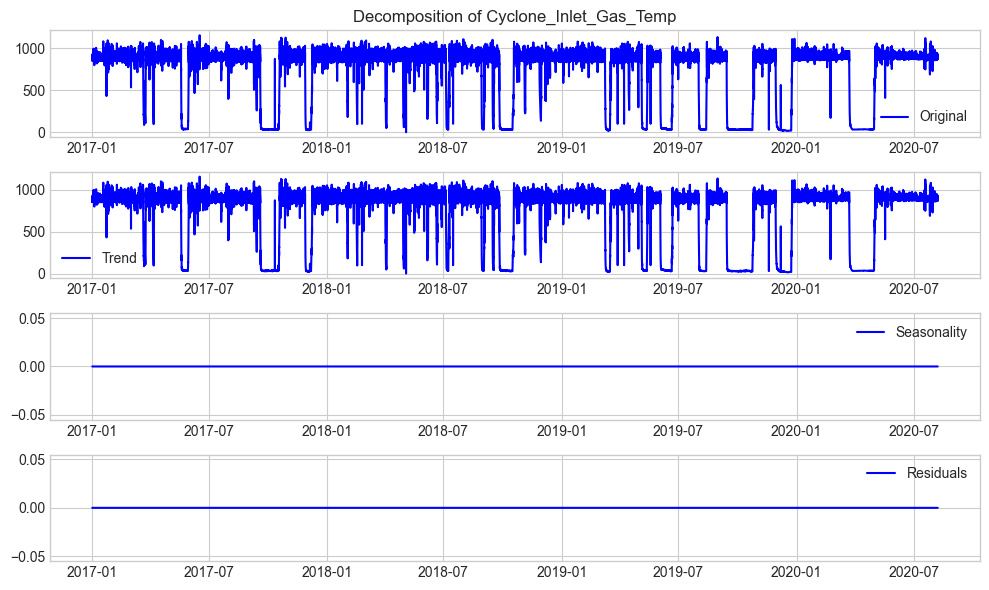

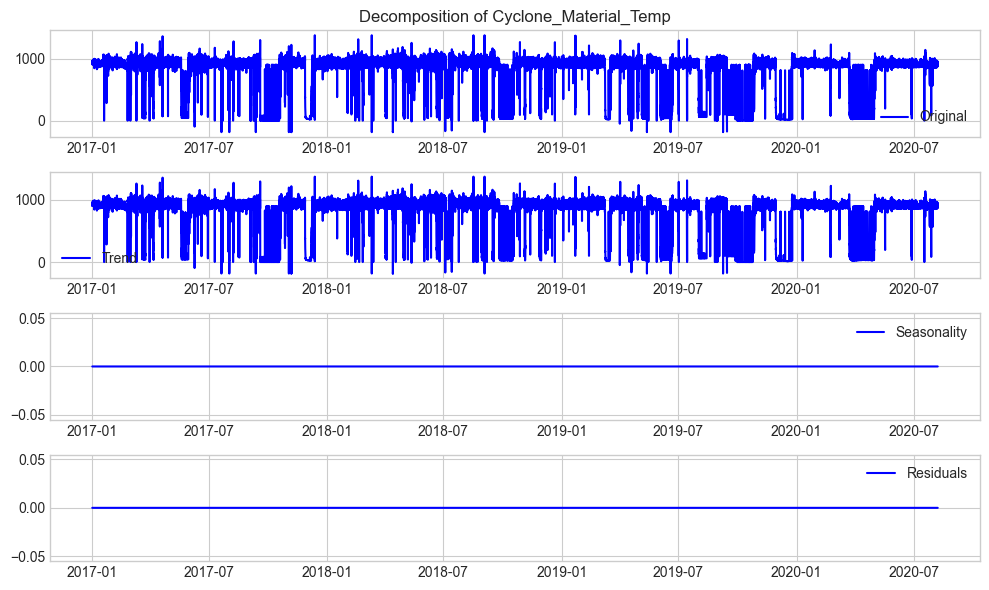

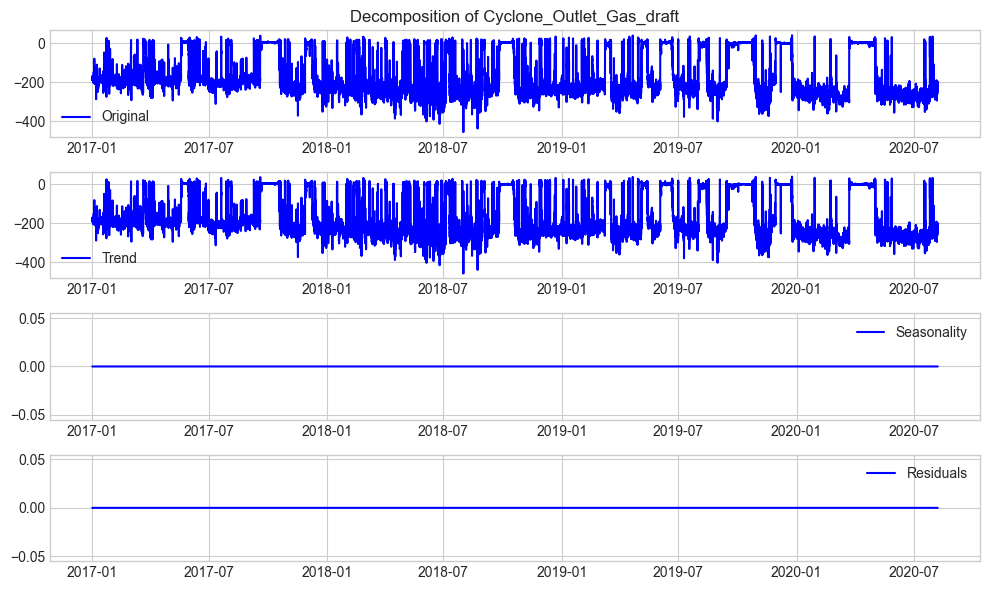

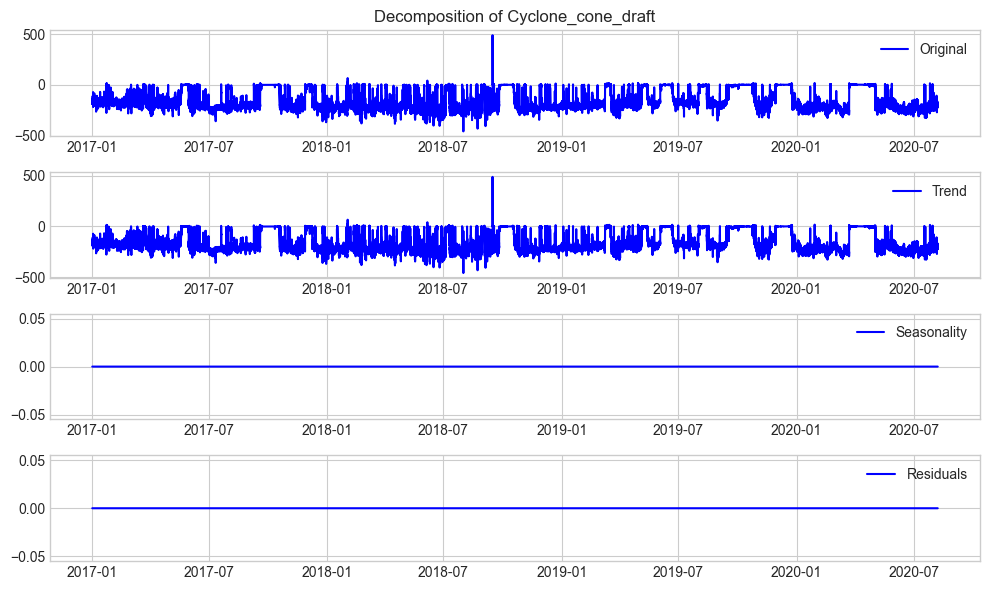

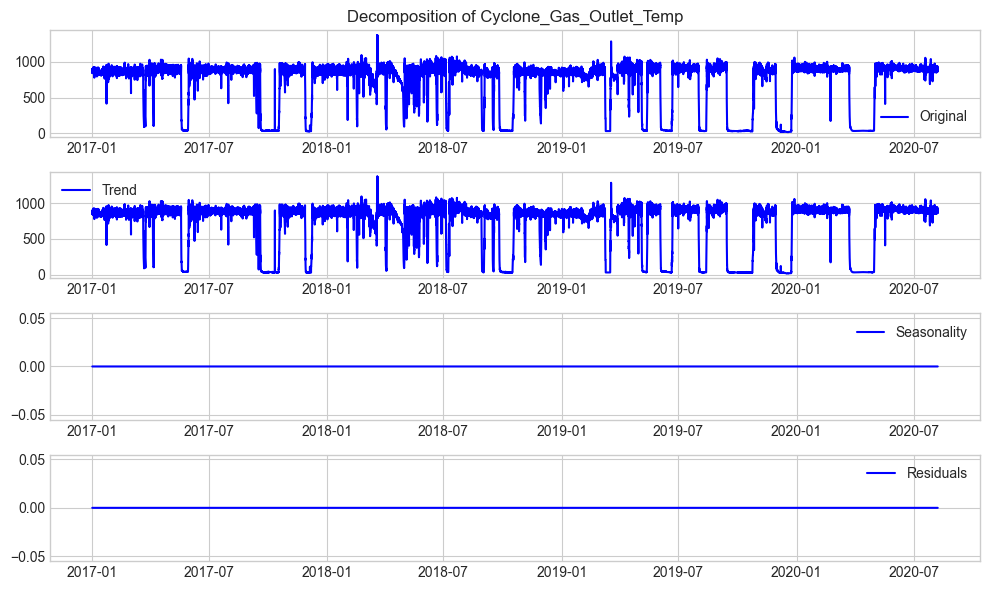

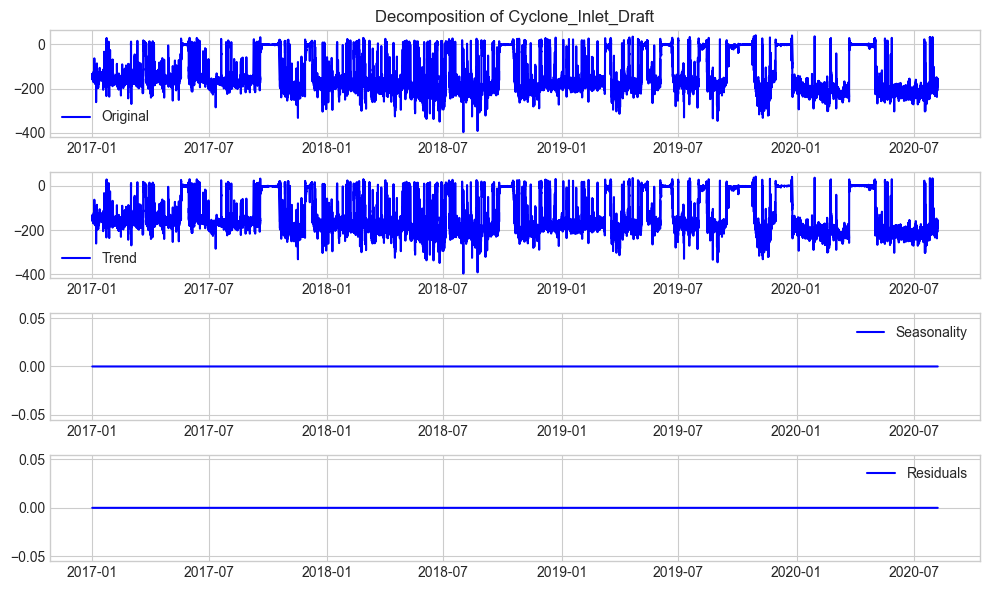

In [29]:
for column in df.columns:
    if column != 'year' and column != 'month':  # Skip 'year' and 'month' columns
        # Perform seasonal decomposition
        decomposed = seasonal_decompose(df[column], model='additive', period=1)
        
        # Extract decomposed components
        trend = decomposed.trend
        seasonal = decomposed.seasonal
        residual = decomposed.resid
        
        # Plot the decomposition
        plt.figure(figsize=(10, 6))
        plt.subplot(411)
        plt.plot(df[column], label='Original', color='blue')
        plt.legend(loc='best')
        plt.title(f'Decomposition of {column}')
        
        plt.subplot(412)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        
        plt.subplot(413)
        plt.plot(seasonal, label='Seasonality', color='blue')
        plt.legend(loc='best')
        
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color='blue')
        plt.legend(loc='best')
        
        plt.tight_layout()
        plt.show()

---

Autocorrelation

---

c:\Users\ATISHAY SG\anaconda3\envs\AIMLSem1\lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


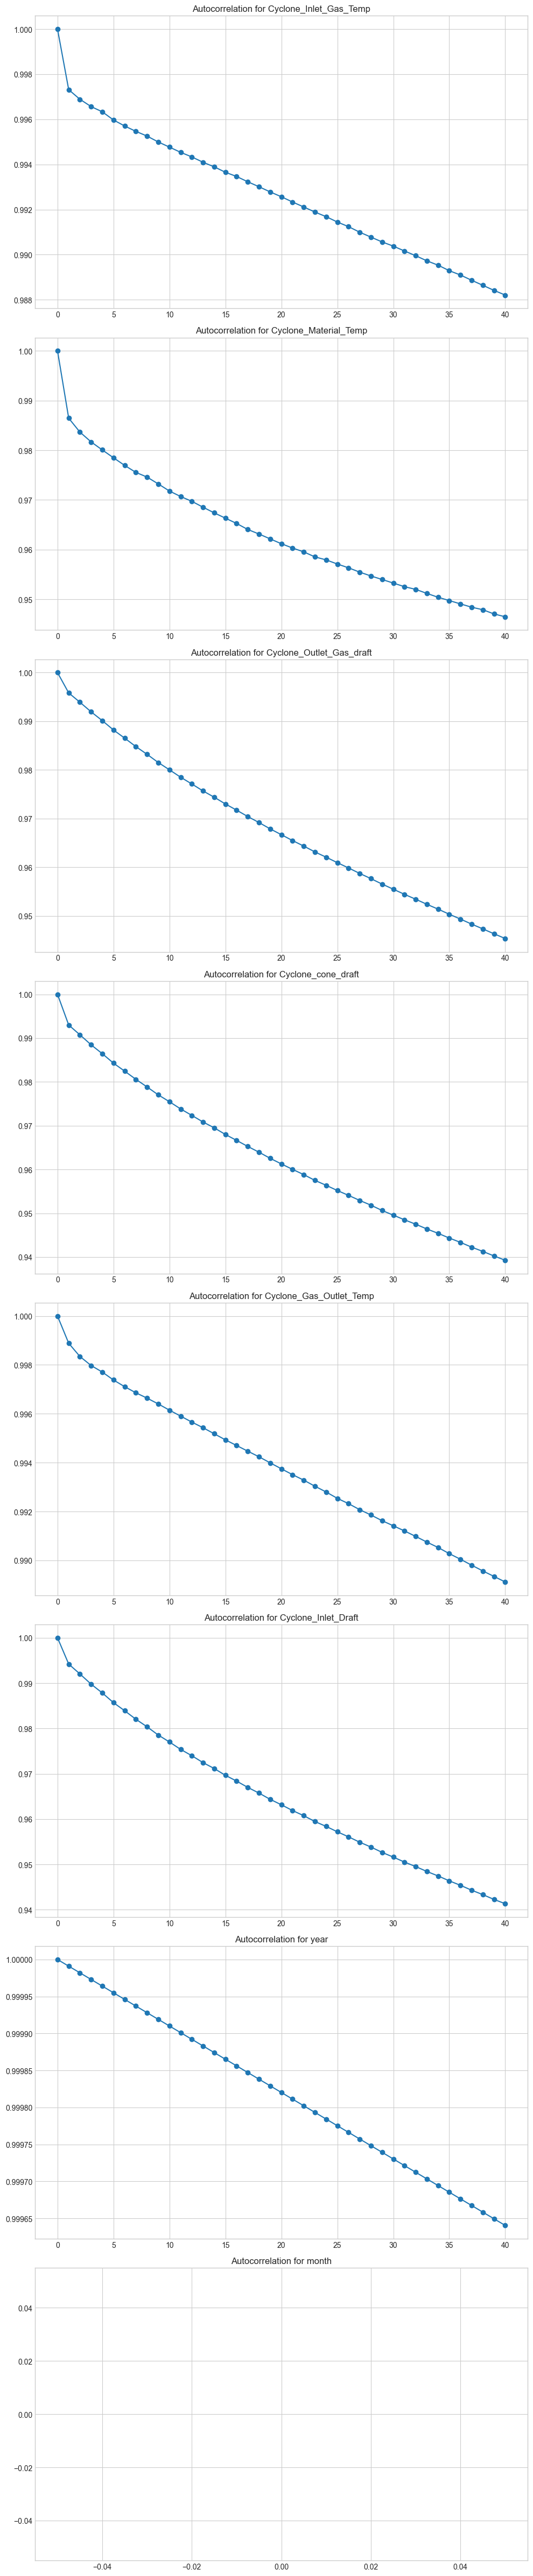

In [55]:
#Autocorrelation is simply the correlation of a series with its own lags.
#Plot lag on x axis and correlation on y axis
#Any correlation above the confidence interval is significant

from statsmodels.tsa.stattools import acf

fig, axs = plt.subplots(len(df.columns), figsize=(10, 6*len(df.columns)))

for i, column in enumerate(df.columns):
    acf_col = acf(df[column], nlags=40)
    axs[i].plot(acf_col, marker='o')
    axs[i].set_title(f'Autocorrelation for {column}')

plt.tight_layout()
plt.show()

In [38]:
# Convert categorical columns to one-hot encoding
df_one_hot = pd.get_dummies(df)

# Now you can use df_one_hot to train your autoencoder

In [18]:
# from sklearn.ensemble import IsolationForest

# # Assuming your data is stored in the 'df_samples' DataFrame
# # Specify the contamination parameter to control the percentage of anomalies detected
# contamination = 0.05  # 5% of the data is considered as anomalies
# model = IsolationForest(contamination=contamination, random_state=42)
# model.fit(df_samples)

# # Predict the anomalies
# anomaly_labels = model.predict(df_samples)
# anomalies = df_samples[anomaly_labels == -1]

# # Print the detected anomalies
# print(anomalies)


In [47]:
# Remove non-numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Convert categorical columns to one-hot encoding
df_one_hot = pd.get_dummies(df)

df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

In [44]:
from keras.models import Model
from keras.layers import Input, Dense

In [49]:
# Define the number of inputs and the size of the latent space
n_inputs = df.shape[1]
latent_space = 10

# Define the encoder
inputs = Input(shape=(n_inputs,))
encoder_layer = Dense(latent_space, activation='relu')(inputs)
encoder = Model(inputs, encoder_layer)

# Define the decoder
decoder_inputs = Input(shape=(latent_space,))
decoder_layer = Dense(n_inputs, activation='sigmoid')(decoder_inputs)
decoder = Model(decoder_inputs, decoder_layer)

# Define the autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)))

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
autoencoder.fit(df, df, epochs=10, batch_size=32, shuffle=True)

Epoch 1/10
11804/11804 [==============================] - 26s 2ms/step - loss: -659230784.0000
Epoch 2/10
11804/11804 [==============================] - 27s 2ms/step - loss: -3851712256.0000
Epoch 3/10
11804/11804 [==============================] - 28s 2ms/step - loss: -9623383040.0000
Epoch 4/10
11804/11804 [==============================] - 22s 2ms/step - loss: -17918416896.0000
Epoch 5/10
11804/11804 [==============================] - 25s 2ms/step - loss: -28709234688.0000
Epoch 6/10
11804/11804 [==============================] - 30s 3ms/step - loss: -41998487552.0000
Epoch 7/10
11804/11804 [==============================] - 28s 2ms/step - loss: -57766895616.0000
Epoch 8/10
11804/11804 [==============================] - 28s 2ms/step - loss: -76007636992.0000
Epoch 9/10
11804/11804 [==============================] - 34s 3ms/step - loss: -96718438400.0000
Epoch 10/10
11804/11804 [==============================] - 22s 2ms/step - loss: -119913881600.0000


In [51]:
from sklearn.model_selection import train_test_split

# Assume 'df' is your DataFrame
# Split the data into a training set and a test set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Now you can use 'df_train' and 'df_test' in your code

In [52]:
# Use the autoencoder to reconstruct the training and testing data
reconstructed_train = autoencoder.predict(df_train)
reconstructed_test = autoencoder.predict(df_test)

# Calculate the reconstruction error
train_error = np.mean(np.abs(df_train - reconstructed_train), axis=1)
test_error = np.mean(np.abs(df_test - reconstructed_test), axis=1)

# Set a threshold for the reconstruction error
threshold = np.percentile(train_error, 95)  # Set threshold at 95th percentile of the training error

# Find anomalies in the training and testing data
train_anomalies = train_error > threshold
test_anomalies = test_error > threshold

2361/2361 [==============================] - 3s 1ms/step


In [53]:
print("Anomalies in training data:", train_anomalies)
print("Anomalies in testing data:", test_anomalies)

Anomalies in training data: time
2018-10-02 14:10:00    False
2019-03-06 17:20:00    False
2018-03-02 06:05:00    False
2017-05-28 08:35:00    False
2018-05-06 01:05:00    False
                       ...  
2019-06-21 22:00:00    False
2020-06-27 06:15:00     True
2018-04-05 02:15:00    False
2018-05-26 22:50:00     True
2018-03-01 11:05:00    False
Length: 302175, dtype: bool
Anomalies in testing data: time
2017-04-25 00:30:00    False
2017-03-15 16:45:00    False
2017-02-06 01:15:00    False
2017-08-13 05:50:00    False
2018-09-20 00:40:00    False
                       ...  
2019-09-09 18:05:00    False
2017-12-12 21:35:00    False
2018-12-06 23:15:00    False
2018-12-01 20:20:00    False
2018-07-25 20:00:00    False
Length: 75544, dtype: bool


11804/11804 [==============================] - 17s 1ms/step


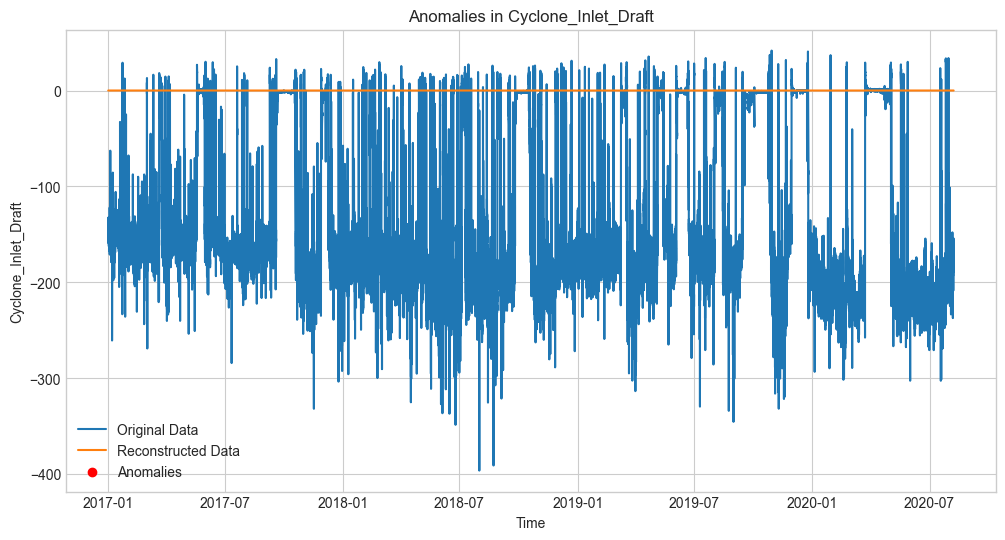

In [54]:
import matplotlib.pyplot as plt

# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cyclone_Inlet_Draft'], label='Original Data')

# Plot reconstructed data
reconstructed_data = autoencoder.predict(df.values)
plt.plot(df.index, reconstructed_data[:, 5], label='Reconstructed Data')

# Identify anomalies
anomalies = df[df['Cyclone_Inlet_Draft'] - reconstructed_data[:, 5] > threshold]
plt.scatter(anomalies.index, anomalies['Cyclone_Inlet_Draft'], color='red', label='Anomalies')

plt.xlabel('Time')
plt.ylabel('Cyclone_Inlet_Draft')
plt.title('Anomalies in Cyclone_Inlet_Draft')
plt.legend()
plt.show()
